# Main testing

In [1]:
import gym
import minihack
import numpy as np
import math
import matplotlib.pyplot as plt
import IPython.display as display
from typing import Tuple, List


## Creazione dell environment

In [2]:
env = gym.make("MiniHack-River-Narrow-v0", observation_keys=("chars", "pixel"))
state = env.reset()
env.render()


Hello Agent, welcome to NetHack!  You are a chaotic male human Rogue.           
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                          ..........@.......}                                   
                          ..................}                                   
                          ........`.........}                                   
                          ......  ..`.......}                                   
                          .

In [3]:
state['chars'].shape, state['pixel'].shape

((21, 79), (336, 1264, 3))

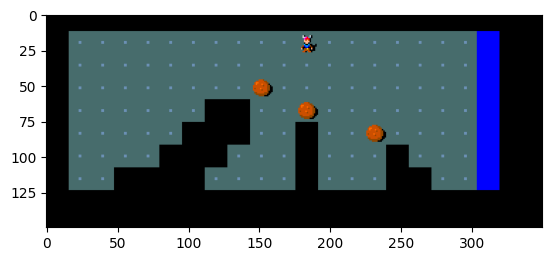

In [4]:
plt.imshow(state['pixel'][100:250, 400:750]) #Immagine ristretta con range [y][x]

In [5]:
game_map = state['chars']
game = state['pixel']

## Cerco le coordinate
Cerco le coordinate del player e di tutti i blocchi presenti sulla mappa e del fiume

In [6]:
#Restituisce la lista delle posizioni di tutti i massi
def get_boulder_locationV(game_map: np.ndarray, symbol : str = "`") -> Tuple[int, int]:
    tuples = np.where(game_map == ord(symbol))
    boulders_positions = list(zip(tuples[0], tuples[1])) #converte la lista di tuple in una lista di liste
    return boulders_positions

In [7]:
#Restituisce la posizione del giocatore
def get_player_location(game_map: np.ndarray, symbol : str = "@") -> Tuple[int, int]:
    x, y = np.where(game_map == ord(symbol))
    return (x[0], y[0])

In [8]:
start = get_player_location(game_map)
boulders = get_boulder_locationV(game_map)
print("Agent position:", start)


Agent position: (7, 36)


Coordinate di tutti i blocchi presenti

In [9]:
boulders

[(9, 34), (10, 36), (11, 39)]

In [10]:
# Trovare la distanza tra due punti senza considerare movimenti diagonali
def manhattan_distance(x1 : int, y1 : int, x2 : int, y2 : int):    
    return abs(x1 - x2) + abs(y1 - y2)
    

In [11]:
# Trova la distanza fra due punti considerando anche movimenti diagonali
def chebyshev_dist(x1 : int, y1 : int, x2 : int, y2 : int): 
    y_dist = abs(y1 - y2)
    x_dist = abs(x1 - x2)
    return max(y_dist, x_dist)

In [12]:
#Trova la minima distanza tra un punto e una serie di punti considerando movimenti diagonali
def min_distance(x,y, list_of_pairs):
    min_dist = 999999999
    for i in list_of_pairs:
        dist = chebyshev_dist(x,y,i[0],i[1])
        if dist < min_dist:
            min_dist = dist
            coordinates = [i[0],i[1]]
    return coordinates, min_dist


Calcolo la distanza del player dal blocco più vicino

In [13]:
target_block_position, distance = min_distance(start[0],start[1],boulders)
print("Target position:", target_block_position, "Distance:", distance)

Target position: [9, 34] Distance: 2


### Cerco le posizioni del fiume

In [14]:
def get_river_locationV(game_map: np.ndarray, symbol : str = "}") -> Tuple[int, int]:
    tuples = np.where(game_map == ord(symbol))
    river_positions = list(zip(tuples[0], tuples[1])) #converte la lista di tuple in una lista di liste
    return river_positions

In [15]:
river_positions = get_river_locationV(game_map)

In [16]:
#Lista con le posizioni del fiume
river_positions

[(7, 44), (8, 44), (9, 44), (10, 44), (11, 44), (12, 44), (13, 44)]

In [17]:
def get_minDist_boulder_to_river(boulderX : int, boulderY : int, river_positions) -> tuple[int,int,int]:
    minDist = 999999999
    for (x,y) in river_positions:
        riverX = x
        riverY = y
        
        dist = manhattan_distance(boulderX,boulderY,riverX,riverY)
        if dist < minDist :
            minDist = dist
            X = riverX
            Y = riverY
            
    return (X,Y,minDist)

In [18]:
boulders[0][0]

9

In [19]:
j = get_minDist_boulder_to_river(boulders[0][0],boulders[0][1], river_positions)

In [20]:
j

(9, 44, 10)

In [21]:
#Get the best distance from player to boulder and boulder to river.

def get_best_global_distance(start: Tuple[int, int], boulders: List[List]) -> Tuple[int, int]:
    distances = []

    for boulder in boulders:
        dist_player_boulder = chebyshev_dist(start[0],start[1], boulder[0], boulder[1])
        
        dist_boulder_river = get_minDist_boulder_to_river(boulder[0],boulder[1], river_positions)
        dist = dist_player_boulder + dist_boulder_river[2]
        distances.append((boulder[0], boulder[1], dist))

    min_distance = min(distances, key=lambda x: x[2])
    return min_distance[0], min_distance[1]
    

In [22]:
#Get the best distance from player to boulder and boulder to river.
def get_best_global_distance2(start: Tuple[int, int], boulder : Tuple[int,int]) -> int:
    boulderX = boulder[0]
    boulderY = boulder[1]
    dist_player_boulder = chebyshev_dist(start[0],start[1], boulderX, boulderY)
    
    dist_boulder_river = get_minDist_boulder_to_river(boulder[0],boulder[1], river_positions)
    dist = dist_player_boulder + dist_boulder_river[2]

    return dist

In [23]:
#Get the best distance from player to boulder and boulder to river.
def get_best_distance_player_to_boulder(start: Tuple[int, int], boulder : Tuple[int,int]) -> int:
    boulderX = boulder[0]
    boulderY = boulder[1]
    dist_player_boulder = chebyshev_dist(start[0],start[1], boulderX, boulderY)
    
    dist = dist_player_boulder -1

    return dist      

In [24]:
def get_best_distance_boulder_to_river(start: Tuple[int, int], boulder : Tuple[int,int]) -> int:
    boulderX = boulder[0]
    boulderY = boulder[1]
    
    dist_boulder_river = get_minDist_boulder_to_river(boulder[0],boulder[1], river_positions)
    dist = dist_boulder_river[2]

    return dist

In [25]:
distances = get_best_global_distance(start, boulders)

In [26]:
distances

(11, 39)

In [27]:
from algorithms import a_star
from utils import *

In [28]:
boulders[0]

(9, 34)

In [29]:
path1 = a_star(game,game_map, start, boulders[1], get_best_distance_player_to_boulder)

KeyError: (10, 36)

In [ ]:
path1

In [ ]:
actions, names = actions_from_path(start, path1[1:])

actions



In [ ]:
names

In [ ]:
agent = get_player_location(game_map)

agent

In [ ]:
#import time
#plot_animated_sequence(game,game_map, actions)



In [ ]:
get_best_distance_boulder_to_river(start, boulders[1])

In [ ]:
plt.imshow(game[:, :])

In [ ]:
coordinates_min_boulder = get_best_global_distance(start, boulders)

In [ ]:
coordinates_min_boulder

## Trying complete path player - boulder - river

In [ ]:
import time

def plot_animated_sequence(game: np.ndarray , game_map : np.ndarray, actions : list[int]):
    image = plt.imshow(game[25:300, :475])
    player_positions = []
    for action in actions:
        s, _, _, _ = env.step(action)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        image.set_data(s['pixel'][:, :])
        player_positions.append(get_player_location(game_map))
        time.sleep(0.5)
    return player_positions

In [ ]:
path_player_boulder = a_star(game,game_map, start, coordinates_min_boulder, get_best_distance_player_to_boulder)
print(path_player_boulder)

In [ ]:
actions, names = actions_from_path(start, path_player_boulder[1: -1])
import time

player_pos = plot_animated_sequence(game, game_map,actions)


In [ ]:
names

In [ ]:
player_pos